In [27]:
# Global setup
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import control
import scipy
import scipy.linalg
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
linkMass = 1.0
motorMass = 0.5
springK = 50.0
numLinks = 1

In [62]:
# want to compute the equations of motions for an SEA system.
def singleSEA():
    
    d = dict()
    d_link = dict()
    d_sea = dict()
    
    # link Model
    # x = [q,q_dot]
    # x = Ax + B tau
    A_link = 1.0*np.array([[0,1],[0,0]])
    B_link = 1.0*np.array([0, 1.0/linkMass])
    
    d_link['A'] = A_link
    d_link['B'] = B_link
    d_link['C'] = np.eye(2)
    d_link['D'] = np.zeros(2)
    
    # SEA model. Locked output assumption with x = [tau, tau_dot]
    # here tau = K(theta - q)
    # know B_motor * theta_ddot + K(theta - q) = tau_m
    # locked output assumption tells us that tau_dot = K theta_dot, tau_ddot = K theta_ddot
    # so then B_motor/springK * tau_ddot + tau = tau_m
    
    M_tau = motorMass/springK
    A_tau = 1.0*np.array([[0,1],[-1.0/M_tau,0]])
    B_tau = 1.0*np.array([0, 1.0/M_tau])
    
    d_sea['A'] = A_tau
    d_sea['B'] = B_tau
    d_sea['C'] = np.eye(2)
    d_sea['D'] = np.zeros(2)
    
    d['link'] = d_link
    d['sea'] = d_sea
    
    # now compute the complete equations
    # linkMass * qddot = K(theta - q)
    # motorMass * thetaddot = -K(theta - q) + tau_m
    H = np.diag([linkMass, motorMass])
    
#     print "C", C
    
    K = springK*np.array([-1,1,0,0])
    KStacked = np.vstack((K,-K))
#     print "KStacked", KStacked
    
    ALower = np.dot(np.linalg.inv(H),KStacked)
    AUpper = np.hstack((np.zeros((2,2)), np.eye(2)))
#     print "AUpper", AUpper
#     print "np.shape(ALowerLeft)", np.shape(ALower)
    
    A_total = np.vstack((AUpper, ALower))
    B_total = np.array([0,0,0,1/motorMass])
    
    d_total = {}
    d_total['A'] = A_total
    d_total['B'] = B_total
    d_total['C'] = np.eye(4,4)
    d_total['D'] = np.zeros(4)
    d['total'] = d_total
    
    return d

def createStateSpaceWithCopy(A,B,C,D):
    
    array = (A,B,C,D)
    m = []
    for i in xrange(0,4):
        matrix = np.asmatrix(np.copy(np.array(array[i])))
#         print type(matrix)
        m.append(matrix)
    
    sys = control.StateSpace(m[0], m[1], m[2], m[3])
#     print type(sys.A)
    return sys


def computeLQRCost(xout, uout, Q, R):
    uCost = np.dot(np.dot(uout.transpose(),R),uout)
    xCost = np.dot(np.dot(xout.transpose(),Q),xout)
    return uCost + xCost

In [33]:
## params
linkQ_lqr = np.diag((100,50))
linkR_lqr = 5.0*np.eye(1)

seaQ_lqr = np.diag((100,50))
seaR_lqr = 5.0*np.eye(1)

A [[ 0.  1.]
 [ 0.  0.]]
B [[ 0.]
 [ 1.]]
C [[ 1.  0.]
 [ 0.  1.]]
D [[ 0.]
 [ 0.]]
Q [[100   0]
 [  0   1]]
R [[ 1.]]
K [[10.          4.58257569]]
<class 'numpy.matrixlib.defmatrix.matrix'>
(1, 100)
lqr gain matrix is [[10.          4.58257569]]


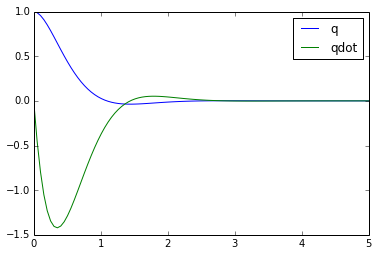

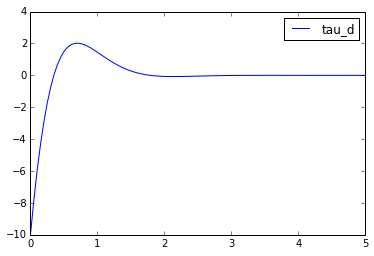

In [22]:
# Link System

verbose = True;

d = singleSEA()
d_sea = d['sea']
d_link = d['link']
A = d_link['A']
B = np.reshape(d_link['B'], (2,1))
C = d_link['C']
D = np.reshape(d_link['D'],(2,1))
B = np.reshape(B,(2,1))

if verbose:
    print "A", A
    print "B", B
    print "C", C
    print "D", D
    
linkSys = control.StateSpace(A,B,C,D)


Q = linkQ_lqr
R = linkR_lqr
K = control.lqr(linkSys, Q, R)[0]

if verbose:
    print "Q", Q
    print "R", R
    print "K", K


# create system that implements the LQR controller
lqrControllerLink = control.StateSpace(1,0*K,0,K)
lqrControllerLink.dt = 0

print type(lqrControllerLink.A)

# feedback the two systems
linkFeedback = control.feedback(linkSys, sys2=lqrControllerLink, sign=-1)
linkFeedback.dt = 0

# print linkSys.inputs
# print linkSys.states
# print linkFeedback.inputs
# print linkFeedback.outputs
# print linkFeedback.states

# simulate this feedback
X0 = np.array([1,0,0]) # initial condition
T = np.linspace(0,5,100)
T, yout, xout = control.forced_response(linkFeedback, T, X0=X0)

tau_d = np.dot(-K,xout[0:2,:])
print np.shape(tau_d)

# plot the output
plt.plot(T,xout[0,:], label='q')
plt.plot(T,xout[1,:], label='qdot')
plt.legend()

plt.figure()
plt.plot(T,tau_d.T, label='tau_d')
plt.legend()

print "lqr gain matrix is", K

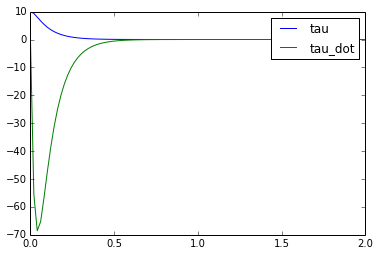

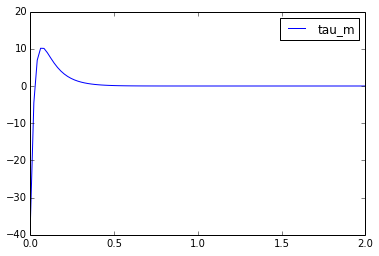

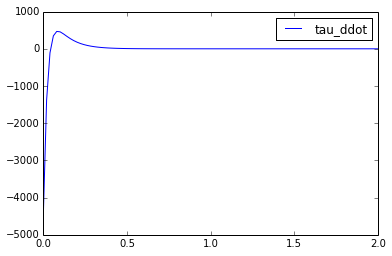

In [23]:
# create the SEA sys
# This is the locked output system
verbose = False

d_sea = d['sea']
A = d_sea['A']
B = np.reshape(d_sea['B'], (2,1))
C = d_sea['C']
D = np.reshape(d_sea['D'],(2,1))
SEAsys = control.StateSpace(A,B,C,D,0)

# get an LQR controller
Q = seaQ_lqr
R = seaR_lqr

KSEA = control.lqr(SEAsys, Q, R)[0]
lqrControllerSEA = control.StateSpace(1,0*KSEA,0,KSEA)
lqrControllerSEA.dt = 0

seaFeedback = control.feedback(SEAsys, sys2=lqrControllerSEA, sign=-1)
seaFeedback.dt = 0
# simulate this feedback
X0 = [10,0] # initial condition, note extra 0 due to "state" of controller
X0_controller = [0]*lqrControllerSEA.states
X0_complete  = X0 + X0_controller
T = np.linspace(0,2,100)
T, yout, xout = control.forced_response(seaFeedback, T, X0=X0_complete)


# plot the output
plt.figure()
plt.plot(T,xout[0,:], label='tau')
plt.plot(T,xout[1,:], label='tau_dot')
plt.legend()

plt.figure()
tau_m = -np.dot(KSEA,xout[0:2,:])
plt.plot(T,tau_m.T, label='tau_m')
plt.legend()


xdot = np.dot(A,xout[0:2,:]) + np.dot(B,tau_m)
plt.figure()
plt.plot(T,xdot[1,:], label='tau_ddot')
plt.legend()

if verbose:
    print A
    print B
    print "lqr gain matrix", KSEA

    print lqrControllerSEA.D
    print KSEA

Q [[ 100.    0.    0.    0.]
 [   0.  100.    0.    0.]
 [   0.    0.   50.    0.]
 [   0.    0.    0.   50.]]
R [[ 5.]]


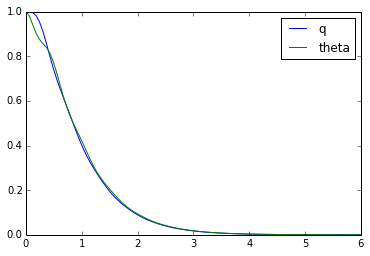

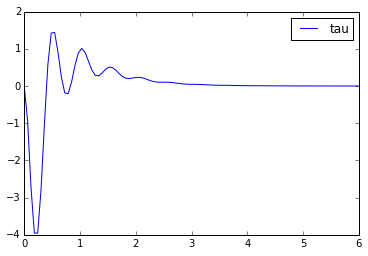

In [63]:
verbose = True

# Simulate the big system with the full lqrController
d_total = d['total']
A = d_total['A']
B = np.reshape(d_total['B'], (4,1))
C = d_total['C']
D = np.reshape(d_total['D'], (4,1))



# this is the full joint + motor system
sys = control.StateSpace(A,B,C,D)

# construct Q matrix from linkQ_lqr and seaQ_lqr
n = numLinks
Q = np.zeros((4*n,4*n))
for i in xrange(0,n):
    Q[i,i] = linkQ_lqr[i,i]
    Q[2*n +i, 2*n + i] = linkQ_lqr[n+i,n+i]
    
    Q[n+i,n+i] = seaQ_lqr[i,i]
    Q[3*n+i,3*n+i] = seaQ_lqr[n+i,n+i]

    
if False:
    Q[1,1] = 10.0
    QLinkCost = 100*np.eye(2*numLinks)
    QSEACost = 50*np.eye(2*numLinks)
    Q = scipy.linalg.block_diag(QLinkCost, QSEACost)
    Q = 100*np.eye(4*numLinks)
    
R = seaR_lqr

if verbose:
    print "Q", Q
    print "R", R
    
K = control.lqr(sys,Q,R)[0]
lqrController = control.StateSpace(1,0*K,[0],K, 0)


feedbackSys = control.feedback(sys, sys2=lqrController, sign=-1)
feedbackSys.dt = 0


X0 = [1,1,0,0] # initial condition
X0_controller = [0]*lqrController.states
X0_complete  = X0 + X0_controller
T = np.linspace(0,6,100)
T, yout, xout = control.forced_response(feedbackSys, T, X0=X0_complete)

plt.figure()
plt.plot(T,xout[0,:], label='q')
plt.plot(T,xout[1,:], label='theta')
plt.legend()

plt.figure()
plt.plot(T,springK*(xout[1,:] - xout[0,:]), label='tau')
plt.legend()

print 


D_tau [[-50.  50.   0.   0.]]
D_taudot [[  0.   0. -50.  50.]]
D_tau_d [[-10.          0.         -4.58257569  0.        ]]
D [[-10.           0.          -4.58257569   0.        ]
 [-50.          50.           0.           0.        ]
 [  0.           0.         -50.          50.        ]]
y is [[-1.  1.  0.]
 [ 0.  0.  1.]]
D_2 is [[ 3.58257569 -3.58257569 -0.52120199]]
yout.shape (4, 100)
controllerSys.states 2
np.shape(xout) (4, 100)


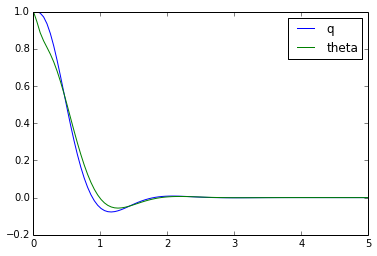

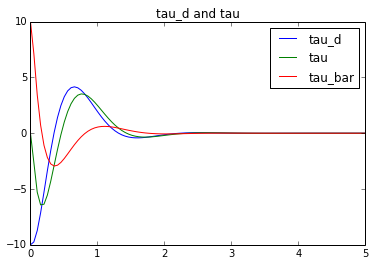

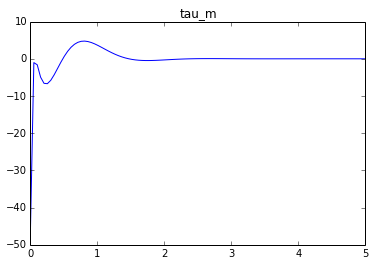

In [56]:
# simulate the full system with the cascaded controller

# outerController
# input: x
# output: [tau_d, tau, K theta_dot]

verbose = True;

n = numLinks # number of links
D_tau_d = np.zeros((n,4*n))
D_tau_d[0:n,0:n] = -lqrControllerLink.D[:,0:n] # q terms
D_tau_d[0:n,2*n:3*n] = -lqrControllerLink.D[:,n:] # qdot terms



helperMatrix = np.zeros((n,2*n))
for i in xrange(0,n):
    helperMatrix[i,i] = -springK
    helperMatrix[i,i+n] = springK

# compute the joint torques
D_tau = np.zeros((n,4*n))
D_tau[0:n,0:2*n] = helperMatrix


D_taudot = np.zeros((n,4*n))
D_taudot[:,2*n:] = helperMatrix


# D is 3n x 4n
D = np.vstack((D_tau_d,D_tau,D_taudot))

print "D_tau", D_tau
print "D_taudot", D_taudot
print "D_tau_d", D_tau_d
print "D", D

m = 1 # num fictitious states
A = np.ones((m,m))
B = np.zeros((m,np.shape(D)[1]))
C = np.zeros((np.shape(D)[0],m))


# takes in q,theta,qdot,thetadot
# outputs [tau_d, tau, tau_dot]
outerController = control.StateSpace(A,B,C,D)


# innerController
# input: outerController.output = [tau_d, tau, tau_dot]
# output: tau_m, which is the motor torque command

# innerController will be connected in series with the outerController

# again will only have D

# ultimately D_inner should be n x 3n
D_1 = np.zeros((n,3*n))
D_1[:,0:n] = np.eye(n)


# y takes [tau_d, tau, tau_dot] --> [tau - tau_d, tau_dot]
y = 1.0*np.zeros((2*n,3*n))
y[0:n,0:n] = -np.eye(n) # tau_d
y[0:n,n:2*n] = np.eye(n) # tau
y[n:,2*n:] = np.eye(n) # tau_dot

if verbose:
    print "y is", y


# takes in [tau_d,tau,tau_dot] and applies the SEA level LQR controller
D_2 = np.dot(-lqrControllerSEA.D, y)

if verbose:
    print "D_2 is", D_2

# just adds back tau_d to get tau_motor
# tau_motor = tau_d  - K_SEA*[tau - tau_d, tau_dot]
D_inner = D_1 + D_2;

m = 1 # num fictitious states, just so control toolbox doesn't do something stupid
A = np.ones((m,m))
B = np.zeros((m,np.shape(D_inner)[1]))
C = np.zeros((np.shape(D_inner)[0],m))

innerController = control.StateSpace(A,B,C,D_inner,0)


# to make the controller just need to series connect outerController -> innerController
controllerSys = control.series(outerController, innerController)

# now want to feedback the controller and the plant
feedbackDecoupledSys = control.feedback(sys, sys2=controllerSys, sign=1)


X0 = [1,1,0,0] # initial condition, link and motor both at position 1
X0_controller = [0]*controllerSys.states # add in the fictitious controller states
X0_complete  = X0 + X0_controller
T = np.linspace(0,5,100)
T, yout, xout_full = control.forced_response(feedbackDecoupledSys, T, X0=X0_complete)

if verbose:
    print "yout.shape", yout.shape
    print "controllerSys.states", controllerSys.states

    
xout = xout_full[0:(4*n),:]
tau = np.dot(D_tau, xout)
tau_dot = np.dot(D_taudot, xout)
tau_d = np.dot(D_tau_d, xout)
theta_d = xout[0,:] + tau_d/springK
tau_bar = tau - tau_d
tau_m = np.dot(controllerSys.D, xout[0:4,:])


plt.plot(T,xout[0,:], label='q')
plt.plot(T,xout[1,:], label='theta')
# plt.plot(T,theta_d.T, label='theta_d')
# plt.plot(T,xout[3,:], label='theta_dot')
plt.legend()


plt.figure()
plt.plot(T, tau_d.T, label='tau_d')

tau = np.dot(D_tau, xout[0:4,:])
plt.plot(T,tau.T, label='tau')



plt.plot(T,tau_bar.T, label='tau_bar')

plt.title('tau_d and tau')
plt.legend()


plt.figure()
plt.plot(T,tau_m.T)
plt.title('tau_m')

# plt.figure()
# # KthetaDot = springK*x[3,:]
# plt.plot(T,xout[3,:], label='theta_dot')
# plt.legend()


if verbose:
    print "np.shape(xout)", np.shape(xout)


In [47]:
# this is only for testing

# input: x
# output: [tau_d, tau, K theta_dot]

verbose = True;

n = numLinks # number of links
D_tau_d = np.zeros((n,4*n))
D_tau_d[0:n,0:n] = -lqrControllerLink.D[:,0:n] # q terms
D_tau_d[0:n,2*n:3*n] = -lqrControllerLink.D[:,n:] # qdot terms



helperMatrix = np.zeros((n,2*n))
for i in xrange(0,n):
    helperMatrix[i,i] = -springK
    helperMatrix[i,i+n] = -springK

# compute the joint torques
D_tau = np.zeros((n,4*n))
D_tau[0:n,0:2*n] = helperMatrix


D_taudot = np.zeros((n,4*n))
D_taudot[:,2*n:] = helperMatrix


print "D_tau", D_tau
print "D_taudot", D_taudot


D_tau [[-50. -50.   0.   0.]]
D_taudot [[  0.   0. -50. -50.]]


In [60]:
a = np.array([[1,2],[3,4]])
print a.transpose()
print a

[[1 3]
 [2 4]]
[[1 2]
 [3 4]]
